In [1]:
########################################################################
# Service version : 1.2.2
# Language        : Python/Jupyter

## Regression-aware Anomaly Detection in Multivariate Time Series Data

Many anomaly detection algorithms are based on a regression model that captures the complex relationship between variables defining the system performance. This service examines the effectiveness of automatic regression model selection procedure to build characteristic healthy behaviour of IoT Assets using the input variables (feature_columns) and output variable (target_column).

The workflow of this notebook is as follows: <br>

1. [Provide Credential.](#packageLoad)
2. [Load Dataset.](#dataLoad)
3. [Compose Anomaly Service and Submit Job.](#pipelineCreation)
4. [Monitor Job](#thresholdstats)
5. [Result Analysis](#groundtruth)

### Credentials

This notebook requires two credentials. Please obtain your own credentials when customizing this notebook for your own work. Please visit __[Anomaly Detection @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/Introduction)__ for trial subscription.

In [3]:
# Credentials required for running notebook

Client_ID = "..."
Client_Secret = "..."


### Load Dataset<a id="dataLoad"></a>

In the data below, we have multiple sensor field representing values from different components. The actual meaning of the values isn't that important for the purpose of this example.

The task of this service is to predict 'Gb1t_avg' using other variables such as 'P_avg', 'Rs_avg', etc. 

In [32]:
# try reading datasets from local files
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

datafile_name = 'Wind_Turbine.csv'
datafile_dir = './datasets/multivariate/sample_data/'
data_df = pd.read_csv(datafile_dir + datafile_name)

data_df.head(10)

,Wind_turbine_name,Date_time,P_avg,Rs_avg,Gb1t_avg,Gb2t_avg,Gost_avg,Git_avg,Yt_avg,Ot_avg,Ws_avg,Wa_avg
0,R80711,1/1/2017 3:10,152.44000,10.73,55.680000,53.849998,44.980000,43.419998,22.480000,-3.12,5.04,181.52000
1,R80711,1/1/2017 3:20,187.89000,11.36,56.759998,55.959999,45.660000,44.220001,19.690001,-3.19,5.13,178.67999
2,R80711,1/1/2017 3:40,82.32000,9.42,53.840000,52.270000,45.439999,42.419998,7.250000,-3.62,4.49,182.61000
3,R80711,1/1/2017 4:10,165.08000,11.00,53.750000,52.680000,45.570000,43.650002,16.680000,-3.75,5.11,183.46001
4,R80711,1/1/2017 4:20,227.57001,11.96,55.820000,55.770000,46.330002,44.910000,18.620001,-3.32,5.84,189.21001
5,R80711,1/1/2017 4:30,240.19000,12.17,57.480000,57.820000,47.119999,45.900002,20.000000,-3.15,5.83,187.58000
6,R80711,1/1/2017 4:40,237.63000,12.11,58.029999,58.110001,47.660000,46.450001,20.930000,-3.00,5.89,208.32001
7,R80711,1/1/2017 4:50,261.67999,12.44,59.250000,59.840000,48.349998,47.299999,21.990000,-2.62,5.85,187.23000
8,R80711,1/1/2017 5:00,198.02000,11.54,59.040001,59.040001,48.720001,47.480000,22.830000,-2.33,5.55,186.36000
9,R80711,1/1/2017 5:10,169.78000,11.04,58.259998,57.689999,48.910000,47.400002,23.110001,-2.38,5.45,186.24001


Below plot shows the sensor data for each of the variables, the user can also choose/resample data based upon the domain knowledge.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

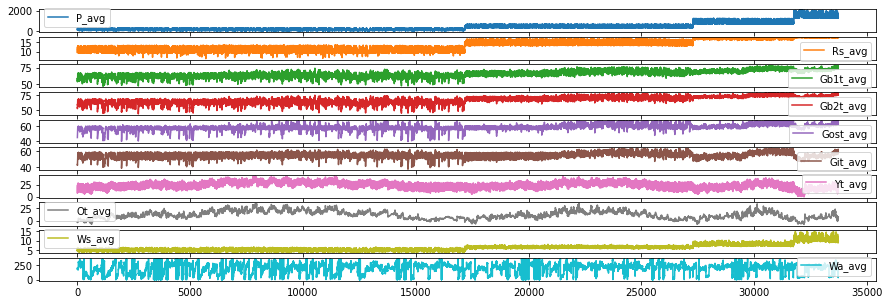

In [33]:
data_df.plot(subplots=True, figsize=(15, 5))

### Anomaly Service Creation and Job Submission <a id="pipelineCreation"></a>

Now, we compose anomaly service. User need to provide a local file name and some meta-data information about the data (target_column, time_column, time_format, etc). The detail of these parameters are available at __[IBM API Hub @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#batch_uni)__ for Univariate Anomaly detection service.

In [36]:
import numpy as np

time_column = "Date_time"
feature_columns = ['Gost_avg', 'Git_avg', 'Rs_avg', 'Ws_avg', 'Wa_avg']
target_columns = 'Gb1t_avg'
time_format="%Y-%m-%d %H:%M:%S"

In [38]:
file_path = datafile_dir + datafile_name
files = {'data_file': (datafile_name, open(file_path, 'rb'))}
data = {
    'feature_columns': str(feature_columns),
    'target_column': target_columns,
    'time_column': time_column,
    'time_format': time_format,
    'dag_type': 'Minimal',
    'evaluation_metrics': 'r2',
    'evaluation_time': 3,
}

headers = {
    'X-IBM-Client-Id': Client_ID,
    'X-IBM-Client-Secret': Client_Secret,
    'accept': "application/json",
    }

import requests
post_response = requests.post("https://api.ibm.com/ai4industry/run/anomaly-detection/timeseries/regression-based/model", 
                              data=data,
                              files=files,
                              headers=headers)

post_r_json = post_response.json()
anomaly_service_jobId = None
if 'jobId' in post_r_json:
    anomaly_service_jobId = post_r_json['jobId']
    print ('submitted successfully job : ', post_r_json['jobId'])
else:
    print (post_r_json)

submitted successfully job :  b56c898f-de5a-4859-8032-9c58dfa05529


### Monitor Anomaly Job <a id="pipelineCreation"></a>

Each anomaly detection service call generates one job id. We now track the progress of job. Detail of job execution is covered at __[Get Result](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#get_result_by_id)__. You may need to the following cell at periodic interval.

In [40]:
get_response = requests.get("https://api.ibm.com/ai4industry/run/result/" + anomaly_service_jobId, headers=headers)
json_data = get_response.json()

print("the status of job {} is {}.".format(anomaly_service_jobId, json_data['status']))

the status of job b56c898f-de5a-4859-8032-9c58dfa05529 is done.


### Anomaly Results <a id="groundtruth"></a>

Now we plot the anomaly score and anomaly label detected by the service.

In [41]:
result = []
result_header = ['ground_truth', 'predictions']

result = [json_data['summary']['ground_truth'], json_data['summary']['predictions']]

result = pd.DataFrame(result).T
result.columns = result_header
result.tail(10)

,ground_truth,predictions
1677,77.56,76.582975
1678,78.21,76.880052
1679,77.41,76.816155
1680,74.39,74.940110
1681,74.38,75.071462
1682,75.89,76.647314
1683,78.00,77.726520
1684,76.21,75.790285
1685,76.64,76.709788
1686,75.11,73.788662


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

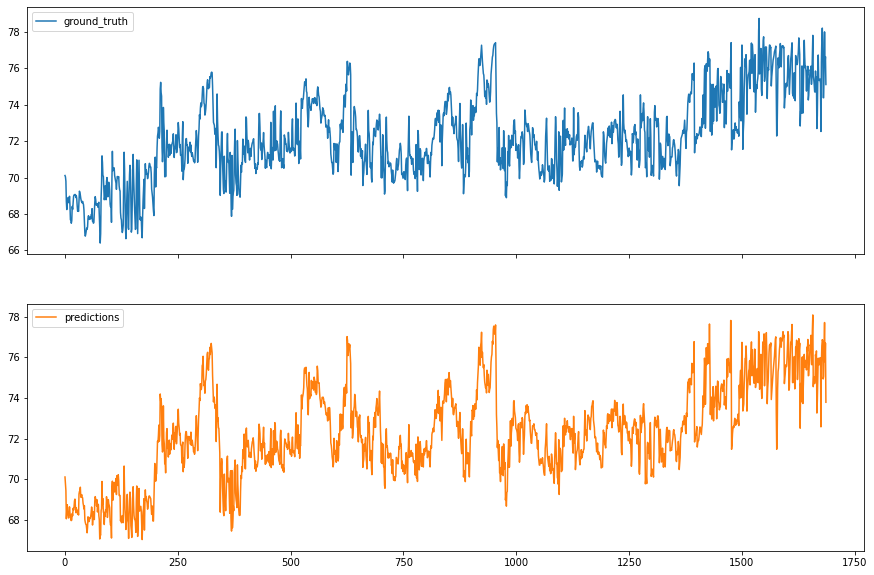

In [42]:
plot_data_df = result.copy()
plot_data_df.plot(subplots=True, figsize=(15, 10))